# Problem Statement

1. IDEAL

The ideal scenario is that the regression model I produce will be able to accurately predict the house price of previously unseen houses with only their features provided. This could be used for investors, estate agents and house sellers to allow for better decision making. It will also allow these stakeholders to make understand what drives prices. Different things will be able to be inferred. It could range from advice on home improvements to potential investment opportunities.


2. REALITY

I have the Ames housing data which has to be cleaned, organised and improved to enable me to tune my model. The data in its current state will not provide a very useful model. 


3. CONSEQUENCES

Without cleaning the data and tuning the model the users wont be able to predict the house prices very accurately. This means that my stakeholders wont be able to have the information they require to make good decisions.


4. PROPOSAL

My proposal is to start by cleaning the data and discover features that have a good correlation to the sales price. I will start by creating a baseline then start modelling with features and see if the baseline can be improved. As I refine and create features these iterations will continuosly improve the model. Success will be an accurate model and wone I can deduce key features and infer some valuable insights for my stakeholders. I will use Linear regression with ridge, lasso and elasticnet regularisation.


N.b. Kaggle Submission and Score will also be a measure of accuracy of the model and project requirement


# Executive Summary

There are some key features in predicting house prices that can give buyers and sellers some important strategies for getting the best house price.

It is hard to know what is important in deciding how much a property is worth and how much investment should be made to increase its current value. If you dont know what these drivers are then expensive mistakes could be made or bargains could be missed.

I have developed a model to predict house prices in the Ames area. It can predict the price given the houses attributes. It has also been used to infer some key features which are important. These include living area, overall quality and key locations. Basements are also important in Ames. However the shape of the property and other external features can affect the price in a negative way.

The model was tested on Kaggle and had an RMSE Score of 35,730. Read more to gain further insights into the Ames housing market.



### Contents:
- [Data Import](#Data-Import)
- [Clean Train Data](#Clean-Train-Data)
- [Clean Test Data](#Clean-Test-Data)


# Data Import

In [3149]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from ast import literal_eval

%matplotlib inline

In [3150]:
# get train and test data sets
ames_train = pd.read_csv('./datasets/inputs/train.csv')
ames_test = pd.read_csv('./datasets/inputs/test.csv')

In [3151]:
# Get data dictionary info to help with exploration
data_dict = pd.read_csv('./datasets/outputs/data_dictionary_df.csv')

In [3152]:
# get saved dictionary to enable quick lookups of column information
file = open("./datasets/outputs/data_dic_reuse.txt", "r")
contents = file.read()
data_dictionary = literal_eval(contents)
file.close()

#### Inspect

In [3153]:
ames_train.shape

(2051, 81)

In [3154]:
ames_test.shape

(879, 80)

#### Rename Columns

In [3155]:
## Train Data
# get column names
cols = list(ames_train.columns)

# replace the spaces and make lower case
new_cols = [x.replace(" ","_").lower() for x in cols]

#create dictionary
new_cols_dic = dict(zip(cols, new_cols))

# rename columns
ames_train.rename(columns=new_cols_dic, inplace=True);

In [3156]:
## Test Data
# get column names
cols = list(ames_test.columns)

# replace the spaces and make lower case
new_cols = [x.replace(" ","_").lower() for x in cols]

#create dictionary
new_cols_dic = dict(zip(cols, new_cols))

# rename columns
ames_test.rename(columns=new_cols_dic, inplace=True);

In [3157]:
# Get the data dictionary dataframe ready for merging
data_dict.drop('Unnamed: 0', axis=1, inplace=True)
data_dict.rename(columns={"index":"feature","clean_dt":"dt"}, inplace=True);

# Clean Train Data

In [3158]:
### Check for nulls

In [3159]:
# Create a dataframe for null values
check_nulls = pd.DataFrame(ames_train.isnull().sum()).copy()
check_nulls.rename(columns={0:"null_count"}, inplace=True)

# reset index
check_nulls.reset_index(inplace=True)
check_nulls.rename(columns={'index':"feature"}, inplace=True)

# Add descriptions so I can make sense of the Features and datatypes
check_nulls = pd.merge(check_nulls,data_dict[['feature','dt','description']],on='feature', how='left')

# Show only Features with misisng data
cols_to_investigate = check_nulls[check_nulls['null_count'] != 0]
cols_to_investigate

,feature,null_count,dt,description
4,lot_frontage,330,float,Linear feet of street connected to property
7,alley,1911,string,Type of alley access to property
26,mas_vnr_type,22,string,Masonry veneer type
27,mas_vnr_area,22,float,Masonry veneer area in square feet
31,bsmt_qual,55,string,Height of the basement
32,bsmt_cond,55,string,General condition of the basement
33,bsmt_exposure,58,string,Walkout or garden level basement walls
34,bsmtfin_type_1,55,string,Quality of basement finished area
35,bsmtfin_sf_1,1,float,Type 1 finished square feet
36,bsmtfin_type_2,56,string,Quality of second finished area (if present)


In [3160]:
# create markdown table to write comments on
table_str = '|Feature|Count|Type|Description|Categories|Impact|Observation|\n|---|---|---|---|---|---|---|\n'
table = cols_to_investigate.to_dict('index')
for key, inner_dic in table.items():
    for k,v in inner_dic.items():
        table_str += '| ' + str(inner_dic[k]) + " "
    table_str += '| | | |\n' 

# print and create md table
#print(table_str)

---

## Observations regarding the Null columns

Number of total rows: 2051

|Feature|Count|Type|Description|Impact|Categories|Observation|
|---|---|---|---|---|---|---|
| lot_frontage | 330 | int | Linear feet of street connected to property |16%| |How many feet of road are connected to a property. Could be considered good or bad. Quite important to deal with as 16% impact|
| alley | 1911 | int | Type of alley access to property |93%|Pave, Grvl | Quite a lot of propertyies probably dont have alley access|
| mas_vnr_type | 22 | str | Masonry veneer type |1% |BrkFace, None, Stone, BrkCmn| Might no be applicable to flats that have no external facing walls|
| mas_vnr_area | 22 | int | Masonry veneer area in square feet |1%| |Might not be applicable to flats that have no external facing walls|
| bsmt_qual | 55 | str | Height of the basement |3%|TA, Gd, Fa, Ex, Po|Missing could indicate that the property doesnt have a basement|
| bsmt_cond | 55 | str | General condition of the basement |3%|TA, Gd, Fa, Po, Ex|Missing could indicate that the property doesnt have a basement|
| bsmt_exposure | 58 | str | Walkout or garden level basement walls |3%|No, Gd, Av, Mn|Missing could indicate that the property doesnt have a basement|
| bsmtfin_type_1 | 55 | str | Quality of basement finished area |3%|GLQ, Unf, ALQ, Rec, BLQ, LwQ  |Could indicate absence of basement. Could impact the price because high quality means that it increases useful sqft of the property which could be valuable.|
| bsmtfin_sf_1 | 1 | int | Type 1 finished square feet |0%||Sq ft of 1st basement. Missing could indicate that the property doesnt have a basement|
| bsmtfin_type_2 | 56 | str | Quality of second finished area (if present) |3%|Unf, Rec, BLQ, GLQ, LwQ, ALQ |Could indicate absence of basement. Could impact the price because high quality means that it increases useful sqft of the property which could be valuable.|
| bsmtfin_sf_2 | 1 | int | Type 2 finished square feet |0% |  |Sq ft of 2nd basement. Missing could indicate that the property doesnt have a basement|
| bsmt_unf_sf | 1 | int | Unfinished square feet of basement area |0%||sqft of unfinished basement. Could be off plan or underconstruction houses. Low impact.|
| total_bsmt_sf | 1 | int | Total square feet of basement area |0%| |Total sq ft of basement. Missing could indicate that the property doesnt have a basement|
| bsmt_full_bath | 2 | int | Basement full bathrooms |0%|0,1,2,3 |number of full basement bathrooms. Not a high impact but would expect houses with 0 to have 0 not NaN|
| bsmt_half_bath | 2 | int | Basement half bathrooms |0%|0,1,2 |number of haf basement bathrooms. Not a high impact but would expect houses with 0 to have 0 not NaN|
| fireplace_qu | 1000 | str | Fireplace quality |49%|TA, Gd, Po, Ex, Fa|Houses without fireplaces would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help|
| garage_type | 113 | str | Garage location |6%|Attchd, Detchd, BuiltIn, Basment, 2Types, CarPort|Houses without garages would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help|
| garage_yr_blt | 114 | int | Year garage was built |6%||Houses without garages would likely to have this column blank. However year would be hard to estimate.|
| garage_finish | 114 | str | Interior finish of the garage |6%|RFn, Unf, Fin|Houses without garages would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help|
| garage_cars | 1 | int | Size of garage in car capacity |0%| |Houses without garages would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help ||
| garage_area | 1 | int | Size of garage in square feet |0%| |Houses without garages would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help ||
| garage_qual | 114 | str | Garage quality |6%|TA, Fa, Gd, Ex, Po|Houses without garages would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help|
| garage_cond | 114 | str | Garage condition |6%|TA, Fa, Po, Gd, Ex| Houses without garages would likely to have this column blank. Need to check but making it categorical and then NaNs to zero could help. |
| pool_qc | 2042 | str | Pool quality |99.9% |Fa, Gd, Ex, TA|Only a few houses have this data and this would because only few have a pools. Therfore this could indicate value and could have a big impact. Therefore I will change this column to dummy data. The NaN will become '0' |
| fence | 1651 | str | Fence quality |80%|MnPrv, GdPrv, GdWo, MnWw|Good Privacy, Minimum Privacy, Good Wood, Minimum Wood/Wire are the categories which could indicate a certain quality of house. I will turn this into duumy data with NaN becoming 0  |
| misc_feature | 1986 | str | Miscellaneous feature not covered in other categories |97%|Shed, TenC, Gar2, Othr, Elev|Contains options such as tennis court, elevator, 2nd garage, shed. This could indicate high value items which could have a big impact. Therefore I will change this column to dummy data. The NaN will become '0' |


In [3161]:
## Select Column You want to explore
dropdown = widgets.Dropdown(options=list(data_dictionary.keys()))
display(dropdown)

Dropdown(options=('mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley', 'lotshape', 'landcont…

In [3162]:
## View Column Attributes - run cell to return selected value above

print(f"Description:\n\t{data_dictionary[dropdown.value][0]}")
print("Categories:")
for x in range(1,len(data_dictionary[dropdown.value][1:])):
    print(f"\t{data_dictionary[dropdown.value][x]}")

Description:
	The building class
Categories:
	20 1-STORY 1946 & NEWER ALL STYLES
	30 1-STORY 1945 & OLDER
	40 1-STORY W/FINISHED ATTIC ALL AGES
	45 1-1/2 STORY - UNFINISHED ALL AGES
	50 1-1/2 STORY FINISHED ALL AGES
	60 2-STORY 1946 & NEWER
	70 2-STORY 1945 & OLDER
	75 2-1/2 STORY ALL AGES
	80 SPLIT OR MULTI-LEVEL
	85 SPLIT FOYER
	90 DUPLEX - ALL STYLES AND AGES
	120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	150 1-1/2 STORY PUD - ALL AGES
	160 2-STORY PUD - 1946 & NEWER
	180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER


# Plan of cleaning

#### These features have a high missing % and may not appear important but I will change to None in case the absence is important or the presence 
+ Pool quality ~99.9%
+ Fence quality 80%
+ Fireplace Quality 49%

#### I will group garage and basement attributes together for research. See if missing attributes means these features are missing from the property
+ Garage
    + garage_type
    + garage_yr_blt
    + garage_finish
    + garage_cars
    + garage_area
    + garage_qual
    + garage_cond
    
    
+ Basement
    + bsmt_qual
    + bsmt_cond
    + bsmt_exposure
    + bsmtfin_type_1
    + bsmtfin_sf_1
    + bsmtfin_type_2
    + bsmtfin_sf_2
    + bsmt_unf_sf
    + total_bsmt_sf
    + bsmt_full_bath
    + bsmt_half_bath
    
#### I will investigate and clean the categories with a high level of NaN and potentially high impact on house price:
+ misc_feature 97%
+ alley 93%
+ lot_frontage 16%

#### Then will investigate and clean the categories with a low level of NaN and potentially lower impact on house price:
+ mas_vnr_type 1%
+ mas_vnr_area 1%

#### Repeat for Test Data

---

### Pool Quality

In [3163]:
ames_train['pool_qc'].isnull().sum()

2042

In [3164]:
ames_train['pool_qc'].value_counts()

Gd    4
TA    2
Fa    2
Ex    1
Name: pool_qc, dtype: int64

In [3165]:
# update to 'None' to allow one hot encoding
ames_train.loc[ames_train['pool_qc'].isnull(),'pool_qc']  = 'None'

In [3166]:
# check changes worked
ames_train['pool_qc'].value_counts()

None    2042
Gd         4
TA         2
Fa         2
Ex         1
Name: pool_qc, dtype: int64

---

### Fence quality

In [3167]:
ames_train['fence'].value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: fence, dtype: int64

In [3168]:
# update to 'None' to allow one hot encoding
ames_train.loc[ames_train['fence'].isnull(),'fence']  = 'None'

In [3169]:
# check changes worked
ames_train['fence'].value_counts()

None     1651
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: fence, dtype: int64

---

### Fireplace quality

In [3170]:
ames_train['fireplace_qu'].value_counts()

Gd    523
TA    407
Fa     59
Ex     31
Po     31
Name: fireplace_qu, dtype: int64

In [3171]:
# update to 'None' to allow one hot encoding
ames_train.loc[ames_train['fireplace_qu'].isnull(),'fireplace_qu']  = 'None'

In [3172]:
# check changes worked
ames_train['fireplace_qu'].value_counts()

None    1000
Gd       523
TA       407
Fa        59
Ex        31
Po        31
Name: fireplace_qu, dtype: int64

### Garage

In [3173]:
garage_feats = ['garage_type','garage_yr_blt','garage_finish','garage_cars','garage_area','garage_qual','garage_cond']

In [3174]:
# check the garage data
ames_train[garage_feats].describe()

,garage_yr_blt,garage_cars,garage_area
count,1937.000000,2050.000000,2050.000000
mean,1978.707796,1.776585,473.671707
std,25.441094,0.764537,215.934561
min,1895.000000,0.000000,0.000000
25%,1961.000000,1.000000,319.000000
50%,1980.000000,2.000000,480.000000
75%,2002.000000,2.000000,576.000000
max,2207.000000,5.000000,1418.000000


#### Observations
+ 2207 looks like a mistake for max year built

In [3175]:
ames_train[['id','year_built','garage_yr_blt']].sort_values(by='garage_yr_blt', ascending=False).head()

,id,year_built,garage_yr_blt
1699,2261,2006,2207.0
1241,317,2009,2010.0
144,105,2010,2010.0
1700,423,2008,2009.0
1732,428,2009,2009.0


In [3176]:
# check what year the house was built
ames_train[garage_feats][ames_train['id'] == 2261]

,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond
1699,Attchd,2207.0,RFn,2.0,502.0,TA,TA


In [3177]:
# change the string data types to 'none'
ames_train.loc[(ames_train['garage_type'].isnull()) & (ames_train['garage_yr_blt'].isnull()) 
                        & (ames_train['garage_finish'].isnull()) & (ames_train['garage_qual'].isnull())
                        & (ames_train['garage_cond'].isnull()) & (ames_train['garage_cars']==0) 
                        & (ames_train['garage_area']==0),
               ['garage_type','garage_finish','garage_qual','garage_cond']] = 'none'


#### I will deduce that the most likely year is 2007. It wouldnt be earlier than this and is certainly more accurate than 2207

In [3178]:
# Change and then check
ames_train.loc[1699,'garage_yr_blt'] = 2007

# check what year the house was built
ames_train[garage_feats][ames_train['id'] == 2261]

,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond
1699,Attchd,2007.0,RFn,2.0,502.0,TA,TA


---

In [3179]:
# check the garage data
ames_train[garage_feats].describe()

,garage_yr_blt,garage_cars,garage_area
count,1937.000000,2050.000000,2050.000000
mean,1978.604543,1.776585,473.671707
std,24.914493,0.764537,215.934561
min,1895.000000,0.000000,0.000000
25%,1961.000000,1.000000,319.000000
50%,1980.000000,2.000000,480.000000
75%,2002.000000,2.000000,576.000000
max,2010.000000,5.000000,1418.000000


#### Change null strings and NaN's
+ change strings 
to 'none' so it can be categorised
+ change int/float NaN's to 0 so it can be categorised - but check for any contradictory data.

In [3180]:
# change the int values data types to 0.0
ames_train.loc[(ames_train['garage_type']=='none') & (ames_train['garage_yr_blt'].isnull()) 
                        & (ames_train['garage_finish']=='none') & (ames_train['garage_qual']=='none')
                        & (ames_train['garage_cond']=='none') & (ames_train['garage_cars']==0) 
                        & (ames_train['garage_area']==0),
               ['garage_area','garage_cars','garage_yr_blt']] = 0.0

In [3181]:
# check it worked
ames_train.loc[(ames_train['garage_type'].isnull()) & (ames_train['garage_yr_blt'].isnull()) 
                        & (ames_train['garage_finish'].isnull()) & (ames_train['garage_qual'].isnull())
                        & (ames_train['garage_cond'].isnull()) & (ames_train['garage_cars']==0) 
                        & (ames_train['garage_area']==0),
               garage_feats]

,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond


In [3182]:
# check nulls
ames_train[garage_feats].isnull().sum()

garage_type      0
garage_yr_blt    1
garage_finish    1
garage_cars      1
garage_area      1
garage_qual      1
garage_cond      1
dtype: int64

In [3183]:
# Isolate remaining cells
ames_train[garage_feats][(ames_train['garage_type'].isnull()) | (ames_train['garage_yr_blt'].isnull()) 
                        | (ames_train['garage_finish'].isnull()) | (ames_train['garage_qual'].isnull())
                        | (ames_train['garage_cars'].isnull()) |(ames_train['garage_area'].isnull())]

,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


#### I dont know if there is a garage. The type says detached. So I will assume there is and change the NaN appropriately therefore no information will be lost.

In [3184]:
#Change text Values
ames_train.loc[ames_train['id'] == 2237,['garage_type','garage_finish','garage_qual','garage_cond']] = 'None'

#Change text Values
ames_train.loc[ames_train['id'] == 2237,['garage_area','garage_cars','garage_yr_blt']] = 0.0

In [3185]:
# list(ames_train['garage_type'].unique())
# ames_train[garage_feats].groupby(['garage_type']).count()

In [3186]:
# check nulls
ames_train[garage_feats].isnull().sum()

garage_type      0
garage_yr_blt    0
garage_finish    0
garage_cars      0
garage_area      0
garage_qual      0
garage_cond      0
dtype: int64

---

### Check Basement data

In [3187]:
# Add basement features to a list
bsmt_feats = ['bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2',
              'bsmt_unf_sf','total_bsmt_sf','bsmt_full_bath','bsmt_half_bath']

In [3188]:
# check nulls
ames_train[bsmt_feats].isnull().sum()

bsmt_qual         55
bsmt_cond         55
bsmt_exposure     58
bsmtfin_type_1    55
bsmtfin_sf_1       1
bsmtfin_type_2    56
bsmtfin_sf_2       1
bsmt_unf_sf        1
total_bsmt_sf      1
bsmt_full_bath     2
bsmt_half_bath     2
dtype: int64

In [3189]:
# check data types
ames_train[bsmt_feats].dtypes

bsmt_qual          object
bsmt_cond          object
bsmt_exposure      object
bsmtfin_type_1     object
bsmtfin_sf_1      float64
bsmtfin_type_2     object
bsmtfin_sf_2      float64
bsmt_unf_sf       float64
total_bsmt_sf     float64
bsmt_full_bath    float64
bsmt_half_bath    float64
dtype: object

In [3190]:
# isolate nulls and change nulls to either 'None' for text columns or '0.0' for the floats
ames_train.loc[(ames_train['bsmt_qual'].isnull()) & (ames_train['bsmt_cond'].isnull()) 
                        & (ames_train['bsmt_exposure'].isnull()) & (ames_train['bsmtfin_type_1'].isnull())
                        & (ames_train['bsmtfin_type_2'].isnull()),
               ['bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2']] = 'None'

ames_train.loc[(ames_train['bsmt_qual']=='None') & (ames_train['bsmt_cond']=='None') 
                        & (ames_train['bsmt_exposure']=='None') & (ames_train['bsmtfin_type_1']=='None')
                        & (ames_train['bsmtfin_type_2']=='None'),
               ['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf','bsmt_full_bath','bsmt_half_bath']] = 0.0


In [3191]:
# check changes
ames_train[bsmt_feats].isnull().sum()

bsmt_qual         0
bsmt_cond         0
bsmt_exposure     3
bsmtfin_type_1    0
bsmtfin_sf_1      0
bsmtfin_type_2    1
bsmtfin_sf_2      0
bsmt_unf_sf       0
total_bsmt_sf     0
bsmt_full_bath    0
bsmt_half_bath    0
dtype: int64

In [3192]:
# check the final values
ames_train[bsmt_feats][(ames_train['bsmt_exposure'].isnull()) | (ames_train['bsmtfin_type_2'].isnull())]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1147,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


+ Row 1147 has a 2nd basement which is currently being built. It should therefore be good quality but its purpose it unknown. So I will add a category called Unknown. 

feature: bsmtfin_type_2
+ Description:
    + Quality of second finished area (if present)
+ Categories:
	+ GLQ Good Living Quarters
	+ ALQ Average Living Quarters
	+ BLQ Below Average Living Quarters
	+ Rec Average Rec Room
	+ LwQ Low Quality
	+ Unf Unfinshed

In [3193]:
# isolate
ames_train.loc[1147,'bsmtfin_type_2']

nan

In [3194]:
# change
ames_train.loc[1147,'bsmtfin_type_2'] = 'None'

In [3195]:
# check
ames_train.loc[1147,'bsmtfin_type_2']

'None'

+ Rows 1456, 1547, 1997 are not finished. I will use the median value of 'No'
feature: bsmt_exposure

+ Description:
	+ Walkout or garden level basement walls
+ Categories:
	+ Gd Good Exposure
	+ Av Average Exposure (split levels or foyers typically score average or above)
	+ Mn Mimimum Exposure
	+ No No Exposure

In [3196]:
ames_train['bsmt_exposure'].value_counts()

No      1339
Av       288
Gd       203
Mn       163
None      55
Name: bsmt_exposure, dtype: int64

In [3197]:
ames_train[bsmt_feats][(ames_train['bsmt_exposure'].isnull()) | (ames_train['bsmtfin_type_2'].isnull())]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


In [3198]:
# Change values
ames_train.loc[[1456],'bsmt_exposure'] = 'No'
ames_train.loc[[1547],'bsmt_exposure'] = 'No'
ames_train.loc[[1997],'bsmt_exposure'] = 'No'

In [3199]:
# Check values have been updated
ames_train.loc[[1456,1547,1997],'bsmt_exposure']

1456    No
1547    No
1997    No
Name: bsmt_exposure, dtype: object

In [3200]:
# Final check for Basement columns
ames_train[bsmt_feats].isnull().sum()

bsmt_qual         0
bsmt_cond         0
bsmt_exposure     0
bsmtfin_type_1    0
bsmtfin_sf_1      0
bsmtfin_type_2    0
bsmtfin_sf_2      0
bsmt_unf_sf       0
total_bsmt_sf     0
bsmt_full_bath    0
bsmt_half_bath    0
dtype: int64

---

### Investigate

+ misc_feature 97%
+ alley 93%
+ lot_frontage 16%

### misc_feature

In [3201]:
ames_train['misc_feature'].isnull().sum()

1986

In [3202]:
ames_train['misc_feature'].value_counts()

Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: misc_feature, dtype: int64

It looks like there are very few features but maybe having an elevator or tennis court might be a key influencer on price. So I will replace the NaN values with 'None'. Then after the visualisation stage I will create dummy columns.

In [3203]:
# Change NaN to 'None'
ames_train.loc[ames_train['misc_feature'].isnull(),['misc_feature']] = 'None'

In [3204]:
# Check changes
ames_train['misc_feature'].value_counts()

None    1986
Shed      56
Gar2       4
Othr       3
Elev       1
TenC       1
Name: misc_feature, dtype: int64

---

### Alley

In [3205]:
# check nulls
ames_train['alley'].isnull().sum()

1911

In [3206]:
# check values
ames_train['alley'].value_counts()

Grvl    85
Pave    55
Name: alley, dtype: int64

Similar to 'misc_feature' there are very few features but maybe it is an influencer on price. So I will replace the NaN values with 'None'. Then after the visualisation stage I will create dummy columns.

In [3207]:
# Change NaN to 'None'
ames_train.loc[ames_train['alley'].isnull(),['alley']] = 'None'

In [3208]:
# Check changes
ames_train['alley'].value_counts()

None    1911
Grvl      85
Pave      55
Name: alley, dtype: int64

---

### lot_frontage

Those 'lot_frontage' has a lot of NaN's. [Frontage](https://www.gimme-shelter.com/frontage-50043/) represents the 'Linear feet of street connected to property'. It has an important impact on price. I will therefore look at some other columns see if there is any useful insights and a way of predicting, otherwise I will take the average.

In [3209]:
# check out lot frontage
ames_train['lot_frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

In [3210]:
# count nulls 
ames_train['lot_frontage'].isnull().sum()

330

In [3211]:
# update lot frontage
ames_train['lot_frontage'][ames_train['lot_frontage'] == 0]

Series([], Name: lot_frontage, dtype: float64)

In [3212]:
# check to see if the house type and frontage are correlated.

In [3213]:
frontage_feats = ['lot_frontage','lot_area','ms_subclass']

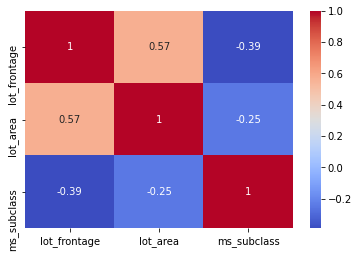

In [3214]:
sns.heatmap(ames_train[frontage_feats].corr(), annot=True, cmap="coolwarm");

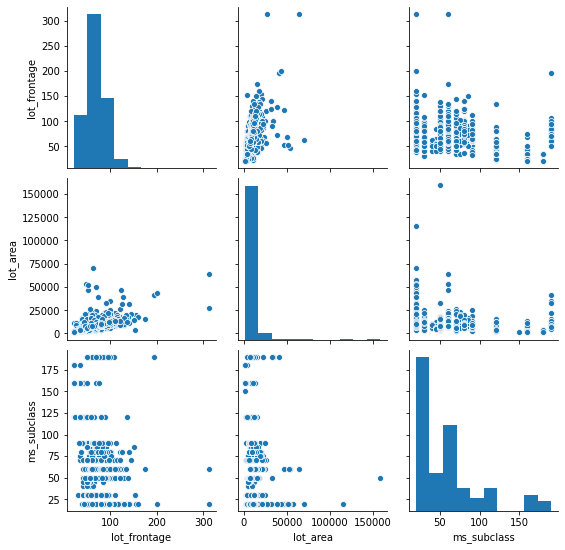

In [3215]:
sns.pairplot(ames_train[frontage_feats]);

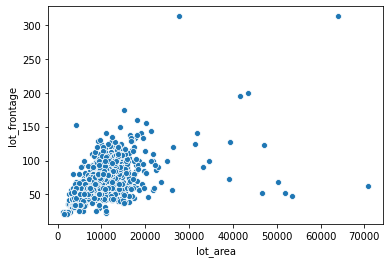

In [3216]:
sns.scatterplot(ames_train['lot_area'],ames_train['lot_frontage']);

lot_frontage and lot_area are correlated. So I will use SLR to estimate the missing points for lot_frontage. However I will compare the baseline of just using the average and compare it againt using SLR. The train test data will be used to decide the accuracy.

In [3217]:
ames_train_no_frontage_nans = ames_train[['id','lot_frontage', 'lot_area']][ames_train['lot_frontage'].isnull() == False]
ames_train_no_frontage_nans

,id,lot_frontage,lot_area
1,544,43.0,11492
2,153,68.0,7922
3,318,73.0,9802
4,255,82.0,14235
5,138,137.0,16492
...,...,...,...
2045,1051,96.0,12444
2046,1587,79.0,11449
2048,916,57.0,7558
2049,639,80.0,10400


### Calculate baseline

In [3218]:
# Remove NaN from test data
test_lot_frontage = ames_train[['id','lot_frontage', 'lot_area']][(ames_train['lot_frontage'].isnull() == False) & 
                                        (ames_train['lot_area'].isnull() == False)]

In [3219]:
X_area = test_lot_frontage[['lot_area']]
y_frontage = test_lot_frontage['lot_frontage']

pandas.core.frame.DataFrame

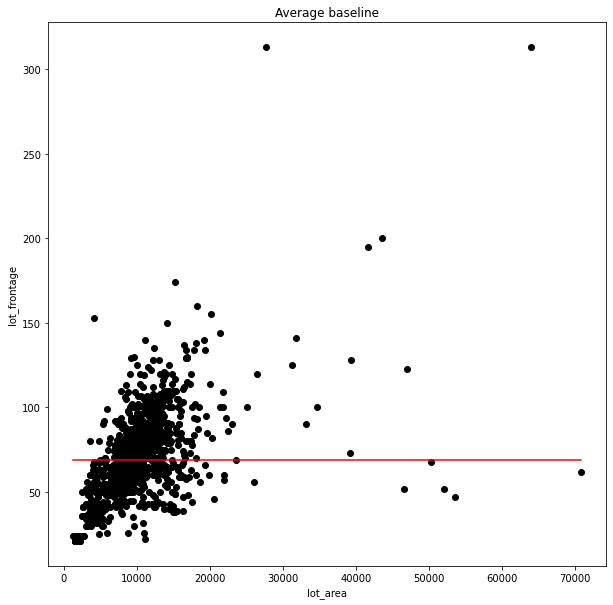

In [3221]:
# plot the data for mean
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

# plot the data
ax.scatter(X_area,y_frontage, c='k')
ax.plot((X_area.min(), 
         X_area.max()),
        (np.mean(y_frontage), 
         np.mean(y_frontage)), color='r');
plt.ylabel('lot_frontage')
plt.xlabel('lot_area')
plt.title('Average baseline');

In [3222]:
# average lot_frontage
average_frontage = np.mean(y_frontage)
average_frontage

69.05520046484602

In [3223]:
# Calculate RMSE for baseline
(np.mean(np.square(y_frontage-average_frontage))) ** 0.5

23.253894551836126

In [3224]:
y_frontage.shape

(1721,)

In [3225]:
y_frontage.values.reshape(-1,1)

array([[43.],
       [68.],
       [73.],
       ...,
       [57.],
       [80.],
       [60.]])

In [3226]:
# create a series to act as the average
avg_frontage = [average_frontage]*1721

pandas.core.series.Series

In [3227]:
# get the RMSE score
np.sqrt(metrics.mean_squared_error(y_frontage, avg_frontage))

23.253894551836126

### Calculate SLR

In [3229]:
# instantiate the model
lr_lot_frontage = LinearRegression()

In [3230]:
lr_lot_frontage.fit(X_area, y_frontage)
lr_lot_frontage.coef_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [3232]:
# get predictions
frontage_prediction = lr_lot_frontage.predict(X_area)

In [3233]:
# get RMSE score
np.sqrt(metrics.mean_squared_error(y_frontage, frontage_prediction))

19.041178372964517

#### Decision
I will use the SLR as it has a better score then using the averages

In [3234]:
frontage_prediction = list(frontage_prediction)
frontage_prediction;

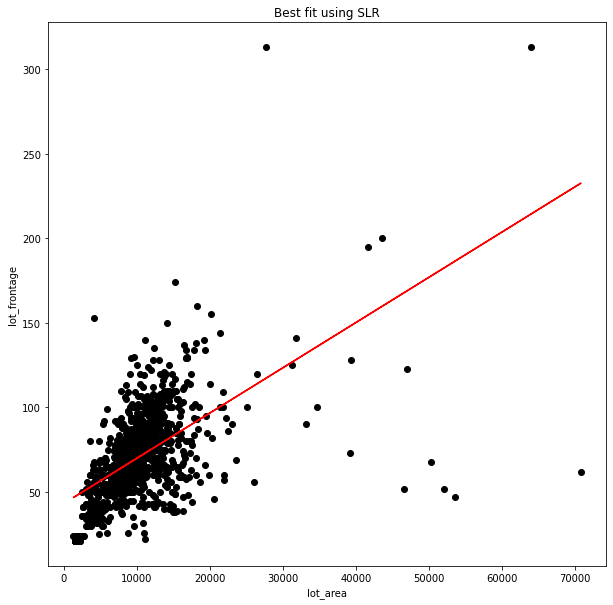

In [3235]:
# plot the data for SLR predictions
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

# plot the data
ax.scatter(X_area, y_frontage, c='k')
ax.plot(X_area, 
         frontage_prediction, color='r');
plt.xlabel('lot_area')
plt.ylabel('lot_frontage')
plt.title('Best fit using SLR');

In [3236]:
#### get predicted values for NaN's
ames_train_frontage_nans = ames_train[['id','lot_frontage', 'lot_area']][ames_train['lot_frontage'].isnull() == True]
ames_train_frontage_nans.head()

,id,lot_frontage,lot_area
0,109,NaN,13517
7,145,NaN,12160
8,1942,NaN,15783
23,12,NaN,7980
27,1534,NaN,11700


In [3237]:
# get the predict values using the prediction model
frontage_prediction_for_nans = lr_lot_frontage.predict(ames_train_frontage_nans['lot_area'].values.reshape(-1,1))

In [3238]:
# add the predictions
ames_train.loc[ames_train['lot_frontage'].isnull(),'lot_frontage'] = predict_frontage_frm_areas

In [3239]:
# check the values have been updated
ames_train['lot_frontage'][ames_train['lot_frontage'].isnull() == True]

Series([], Name: lot_frontage, dtype: float64)

---

### Now investigate 
+ mas_vnr_type 1%
+ mas_vnr_area 1%

In [3240]:
ames_train.loc[:,['bldg_type','house_style','overall_qual','overall_cond','roof_style','roof_matl','exterior_1st',
                  'exterior_2nd','mas_vnr_type','mas_vnr_area','exter_qual','exter_cond']].head()

,bldg_type,house_style,overall_qual,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond
0,1Fam,2Story,6,8,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA
1,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA
2,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd
3,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA
4,1Fam,1.5Fin,6,8,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA


In [3241]:
ames_train.loc[:,['bldg_type','house_style','overall_qual','overall_cond','roof_style','roof_matl','exterior_1st',
                  'exterior_2nd','mas_vnr_type','mas_vnr_area','exter_qual','exter_cond']].tail()

,bldg_type,house_style,overall_qual,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond
2046,1Fam,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA
2047,1Fam,1Story,4,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA
2048,1Fam,1.5Fin,6,6,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA
2049,1Fam,1Story,4,5,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA
2050,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA


In [3242]:
# See if the nulls occur on the same rows

ames_train.loc[:,['bldg_type','house_style','overall_qual','overall_cond','roof_style',
                  'roof_matl','exterior_1st','exterior_2nd','mas_vnr_type','mas_vnr_area',
                  'exter_qual','exter_cond']][(ames_train['mas_vnr_type'].isnull() == True) & 
                                              (ames_train['mas_vnr_area'].isnull() == True)]

,bldg_type,house_style,overall_qual,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond
22,1Fam,2Story,8,5,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA
41,1Fam,1Story,10,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA
86,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA
212,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA
276,1Fam,1Story,6,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,TA,TA
338,1Fam,2Story,8,5,Hip,CompShg,WdShing,Wd Shng,NaN,NaN,Gd,TA
431,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA
451,1Fam,1Story,8,5,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA
591,TwnhsE,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA
844,TwnhsE,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA


In [3243]:
# Check unique values
ames_train['mas_vnr_type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

#### observation
There doesnt look like there patterns to explore so I will replace mas_vnr_type NaN's with 'Unknown'. Therefore is I create dummy categories then if there is meaning then it wont be lost.

In [3244]:
mas_vnr_area_df = ames_train.loc[:,['bldg_type','house_style','overall_qual','overall_cond','roof_style',
                  'roof_matl','exterior_1st','exterior_2nd','mas_vnr_type','mas_vnr_area',
                  'exter_qual','exter_cond']][ames_train['mas_vnr_area'].isnull() == False]

In [3245]:
mas_vnr_area_df['mas_vnr_area'].describe()

count    2029.000000
mean       99.695909
std       174.963129
min         0.000000
25%         0.000000
50%         0.000000
75%       161.000000
max      1600.000000
Name: mas_vnr_area, dtype: float64

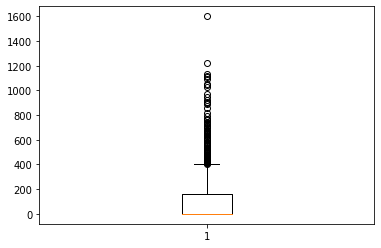

In [3246]:
plt.boxplot(mas_vnr_area_df['mas_vnr_area']);

This shows that up to the 75% quartile the values are low below 161. The Median is 0 so I will use this as using the mean of ~100 is likely to give it a higher representative number. Especially as its mostly likely the is 0 as this is the median and also the 'mas_vnr_type' has been left out.

In [3247]:
# update values

ames_train.loc[ames_train['mas_vnr_type'].isnull(),'mas_vnr_type'] = 'Unknown'
ames_train.loc[ames_train['mas_vnr_area'].isnull(),'mas_vnr_area'] = 0.0


### Check the overall NaN values

In [3248]:
summary_df = pd.DataFrame(ames_train.isnull().sum()).copy()
summary_df[0] = summary_df[0].map(lambda x: str(x)) 
summary_df[0][summary_df[0] != 0].sort_values(ascending=False).head(4)

saleprice         0
total_bsmt_sf     0
year_remod/add    0
roof_style        0
Name: 0, dtype: object

There are only the 3 columns left with NaN's, these I planned to exclude for the first model.

In [3249]:
# Save Data
ames_train.to_csv('./datasets/outputs/data_cleaning_train_1.0.csv')

---

# Clean Test Data

In [3250]:
# Create a dataframe for null values
check_nulls_test = pd.DataFrame(ames_test.isnull().sum()).copy()
check_nulls_test.rename(columns={0:"null_count"}, inplace=True)

# reset index
check_nulls_test.reset_index(inplace=True)
check_nulls_test.rename(columns={'index':"feature"}, inplace=True)

# Add descriptions so I can make sense of the Features and datatypes
check_nulls_test = pd.merge(check_nulls_test, data_dict[['feature','dt','description']],on='feature', how='left')

# Show only Features with misisng data
cols_to_investigate_test_set = check_nulls_test[check_nulls_test['null_count'] != 0]
cols_to_investigate_test_set

,feature,null_count,dt,description
4,lot_frontage,160,float,Linear feet of street connected to property
7,alley,821,string,Type of alley access to property
26,mas_vnr_type,1,string,Masonry veneer type
27,mas_vnr_area,1,float,Masonry veneer area in square feet
31,bsmt_qual,25,string,Height of the basement
32,bsmt_cond,25,string,General condition of the basement
33,bsmt_exposure,25,string,Walkout or garden level basement walls
34,bsmtfin_type_1,25,string,Quality of basement finished area
36,bsmtfin_type_2,25,string,Quality of second finished area (if present)
43,electrical,1,string,Electrical system


In [3251]:
# create markdown table to write comments on
table_str = '|Feature|Count|Type|Description|Categories|Impact|Observation|\n|---|---|---|---|---|---|---|\n'
table = cols_to_investigate_test_set.to_dict('index')
for key, inner_dic in table.items():
    for k,v in inner_dic.items():
        table_str += '| ' + str(inner_dic[k]) + " "
    table_str += '| | | |\n' 

# print and create md table
#print(table_str)

|Feature|Count|Type|Description|Categories|Impact|Observation|
|---|---|---|---|---|---|---|
| lot_frontage | 160 | float | Linear feet of street connected to property | | | |
| alley | 821 | string | Type of alley access to property | | | |
| mas_vnr_type | 1 | string | Masonry veneer type | | | |
| mas_vnr_area | 1 | float | Masonry veneer area in square feet | | | |
| bsmt_qual | 25 | string | Height of the basement | | | |
| bsmt_cond | 25 | string | General condition of the basement | | | |
| bsmt_exposure | 25 | string | Walkout or garden level basement walls | | | |
| bsmtfin_type_1 | 25 | string | Quality of basement finished area | | | |
| bsmtfin_type_2 | 25 | string | Quality of second finished area (if present) | | | |
| electrical | 1 | string | Electrical system | | | |
| fireplace_qu | 422 | string | Fireplace quality | | | |
| garage_type | 44 | string | Garage location | | | |
| garage_yr_blt | 45 | float | Year garage was built | | | |
| garage_finish | 45 | string | Interior finish of the garage | | | |
| garage_qual | 45 | string | Garage quality | | | |
| garage_cond | 45 | string | Garage condition | | | |
| pool_qc | 875 | string | Pool quality | | | |
| fence | 707 | string | Fence quality | | | |
| misc_feature | 838 | string | Miscellaneous feature not covered in other categories | | | |

### Observations
The issues that the train set are very similar to the test set. The only difference is the 1 electrical issue. I will investigate this but then treat the NaN's the same as the Training data.

---

### Investigate electrical

In [3252]:
ames_test.groupby('electrical')['electrical'].count()

electrical
FuseA     48
FuseF     15
FuseP      1
SBrkr    814
Name: electrical, dtype: int64

I will use the mode and median values rather than removing the row. Therefore it will become 'SBrkr'.

In [3253]:
# Find row 
ames_test[['id','electrical']][ames_test['electrical'].isnull()]

,id,electrical
635,1578,NaN


In [3254]:
# isolate and change
ames_test['electrical'][(ames_test['electrical'].isnull()) & (ames_test['id'] == 1578)]
ames_test.loc[635:635,'electrical'] = 'SBrkr'

In [3255]:
# show and check
ames_test.loc[635:635,'electrical']

635    SBrkr
Name: electrical, dtype: object

### Pool Quality

In [3256]:
# check the values
ames_test['pool_qc'].value_counts()

Ex    3
TA    1
Name: pool_qc, dtype: int64

In [3257]:
ames_test['pool_qc'].isnull() == True

0      True
1      True
2      True
3      True
4      True
       ... 
874    True
875    True
876    True
877    True
878    True
Name: pool_qc, Length: 879, dtype: bool

In [3258]:
ames_test.loc[ames_test['pool_qc'].isnull(),'pool_qc']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
874    NaN
875    NaN
876    NaN
877    NaN
878    NaN
Name: pool_qc, Length: 875, dtype: object

####  Decision
Update to 'None' to allow one hot encoding

In [3259]:
ames_test.loc[ames_test['pool_qc'].isnull(),'pool_qc']  = 'None'

In [3260]:
# check changes worked
ames_test['pool_qc'].value_counts()

None    875
Ex        3
TA        1
Name: pool_qc, dtype: int64

---

### Fence quality

In [3261]:
ames_test['fence'].value_counts()

MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: fence, dtype: int64

####  Decision
Update to 'None' to allow one hot encoding

In [3262]:
ames_test.loc[ames_test['fence'].isnull(),'fence']  = 'None'

In [3263]:
# check changes worked
ames_test['fence'].value_counts()

None     707
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: fence, dtype: int64

---



### Fireplace quality

In [3264]:
ames_test['fireplace_qu'].value_counts()

Gd    221
TA    193
Fa     16
Po     15
Ex     12
Name: fireplace_qu, dtype: int64

####  Decision
Update to 'None' to allow one hot encoding

In [3265]:
ames_test.loc[ames_test['fireplace_qu'].isnull(), 'fireplace_qu']  = 'None'

In [3266]:
# check changes worked
ames_test['fireplace_qu'].value_counts()

None    422
Gd      221
TA      193
Fa       16
Po       15
Ex       12
Name: fireplace_qu, dtype: int64

---

### Garage data

In [3267]:
ames_test[garage_feats].isnull().sum()

garage_type      44
garage_yr_blt    45
garage_finish    45
garage_cars       0
garage_area       0
garage_qual      45
garage_cond      45
dtype: int64

In [3268]:
# Calculate any with all missing info for categorical data
ames_test.loc[(ames_test['garage_type'].isnull()) & (ames_test['garage_yr_blt'].isnull()) 
                        & (ames_test['garage_finish'].isnull()) & (ames_test['garage_qual'].isnull())
                        & (ames_test['garage_cond'].isnull()),
               ['garage_type','garage_finish','garage_qual','garage_cond']].shape


(44, 4)

In [3269]:
ames_test.loc[(ames_test['garage_type'].isnull()) & (ames_test['garage_yr_blt'].isnull()) 
                        & (ames_test['garage_finish'].isnull()) & (ames_test['garage_qual'].isnull())
                        & (ames_test['garage_cond'].isnull()),
               ['garage_type','garage_finish','garage_qual','garage_cond']] = 'None'

In [3270]:
ames_test[garage_feats].isnull().sum()

garage_type       0
garage_yr_blt    45
garage_finish     1
garage_cars       0
garage_area       0
garage_qual       1
garage_cond       1
dtype: int64

In [3271]:
# find left over row
ames_test.loc[(ames_test['garage_yr_blt'].isnull()) & (ames_test['garage_finish'].isnull()) &
              (ames_test['garage_qual'].isnull()) & (ames_test['garage_cond'].isnull()),
               ['garage_finish','garage_qual','garage_cond']]

,garage_finish,garage_qual,garage_cond
765,NaN,NaN,NaN


In [3272]:
# find left over row
ames_test.loc[(ames_test['garage_yr_blt'].isnull()) & (ames_test['garage_finish'].isnull()) &
              (ames_test['garage_qual'].isnull()) & (ames_test['garage_cond'].isnull()),
               ['garage_finish','garage_qual','garage_cond']] = 'None'

In [3273]:
# check changes made
ames_test[garage_feats].isnull().sum()

garage_type       0
garage_yr_blt    45
garage_finish     0
garage_cars       0
garage_area       0
garage_qual       0
garage_cond       0
dtype: int64

In [3307]:
# update
ames_test.loc[ames_test['garage_yr_blt'].isnull(), 'garage_yr_blt'] = 0


In [3275]:
ames_test.isnull().sum().sort_values(ascending=False).head(9)

misc_feature      838
alley             821
lot_frontage      160
bsmt_qual          25
bsmtfin_type_2     25
bsmtfin_type_1     25
bsmt_exposure      25
bsmt_cond          25
mas_vnr_area        1
dtype: int64

---

### Basement data

In [3276]:
bsmt_feats = ['bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2',
              'bsmt_unf_sf','total_bsmt_sf','bsmt_full_bath','bsmt_half_bath']

In [3277]:
ames_test[bsmt_feats].isnull().sum().sort_values(ascending=False).head(6)

bsmtfin_type_2    25
bsmtfin_type_1    25
bsmt_exposure     25
bsmt_cond         25
bsmt_qual         25
bsmt_half_bath     0
dtype: int64

In [3278]:
#check data types
ames_test[bsmt_feats].dtypes

bsmt_qual         object
bsmt_cond         object
bsmt_exposure     object
bsmtfin_type_1    object
bsmtfin_sf_1       int64
bsmtfin_type_2    object
bsmtfin_sf_2       int64
bsmt_unf_sf        int64
total_bsmt_sf      int64
bsmt_full_bath     int64
bsmt_half_bath     int64
dtype: object

In [3279]:
# isolate nulls and change nulls to either 'None' for text columns or '0.0' for the floats
ames_test.loc[(ames_test['bsmt_qual'].isnull()) & (ames_test['bsmt_cond'].isnull()) 
                        & (ames_test['bsmt_exposure'].isnull()) & (ames_test['bsmtfin_type_1'].isnull())
                        & (ames_test['bsmtfin_type_2'].isnull()),
               ['bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2']] = 'None'

In [3280]:
# Check basement is done
ames_test[bsmt_feats].isnull().sum()

bsmt_qual         0
bsmt_cond         0
bsmt_exposure     0
bsmtfin_type_1    0
bsmtfin_sf_1      0
bsmtfin_type_2    0
bsmtfin_sf_2      0
bsmt_unf_sf       0
total_bsmt_sf     0
bsmt_full_bath    0
bsmt_half_bath    0
dtype: int64

---

### Clean mas_vnr_type and mas_vnr_area

In [3281]:
ames_test.loc[:,['bldg_type','house_style','overall_qual','overall_cond','roof_style',
                  'roof_matl','exterior_1st','exterior_2nd','mas_vnr_type','mas_vnr_area',
                  'exter_qual','exter_cond']][(ames_test['mas_vnr_type'].isnull() == True) & 
                                              (ames_test['mas_vnr_area'].isnull() == True)]

,bldg_type,house_style,overall_qual,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond
866,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA


In [3282]:
# Just one row to be cleaned by making the area 0 and 'Unknown'
ames_test.loc[866,'mas_vnr_type'] = 'Unknown'
ames_test.loc[866,'mas_vnr_area'] = 0

In [3283]:
ames_test.loc[866,'mas_vnr_type'], ames_test.loc[866,'mas_vnr_area']

('Unknown', 0.0)

In [3284]:
# check data set
ames_test.isnull().sum().sort_values(ascending=False).head(7)

misc_feature    838
alley           821
lot_frontage    160
sale_type         0
exter_cond        0
roof_style        0
roof_matl         0
dtype: int64

---

### Misc Features

In [3285]:
ames_test['misc_feature'].isnull().sum()

838

In [3286]:
ames_test['misc_feature'].value_counts()

Shed    39
Gar2     1
Othr     1
Name: misc_feature, dtype: int64

#### Decision
It looks like there are very few features but maybe having an elevator or tennis court might be a key influencer on price. So I will replace the NaN values with 'None'. Then after the visualisation stage I will create dummy columns.

In [3287]:
# Change NaN to 'None'
ames_test.loc[ames_test['misc_feature'].isnull(),['misc_feature']] = 'None'

In [3288]:
# Check changes
ames_test['misc_feature'].value_counts()

None    838
Shed     39
Gar2      1
Othr      1
Name: misc_feature, dtype: int64

---

### Alley

In [3289]:
ames_test['alley'].isnull().sum()

821

In [3290]:
ames_test['alley'].value_counts()

Grvl    35
Pave    23
Name: alley, dtype: int64

#### Decision
Similar to 'misc_feature' there are very few features but maybe it is an influencer on price. So I will replace the NaN values with 'None'. Then after the visualisation stage I will create dummy columns.

In [3291]:
# Change NaN to 'None'
ames_test.loc[ames_test['alley'].isnull(),['alley']] = 'None'

In [3292]:
# Check changes
ames_test['alley'].value_counts()

None    821
Grvl     35
Pave     23
Name: alley, dtype: int64

In [3293]:
# check data set
ames_test.isnull().sum().sort_values(ascending=False).head(5)

lot_frontage    160
sale_type         0
exter_cond        0
roof_style        0
roof_matl         0
dtype: int64

---

### Lot Frontage

I will use the SLR model to estimate nulls again

In [3294]:
frontage_prediction = lr_lot_frontage.predict(X_area)

In [3295]:
np.sqrt(metrics.mean_squared_error(y_frontage, frontage_prediction))

19.041178372964517

In [3296]:
frontage_prediction = list(frontage_prediction)
frontage_prediction;

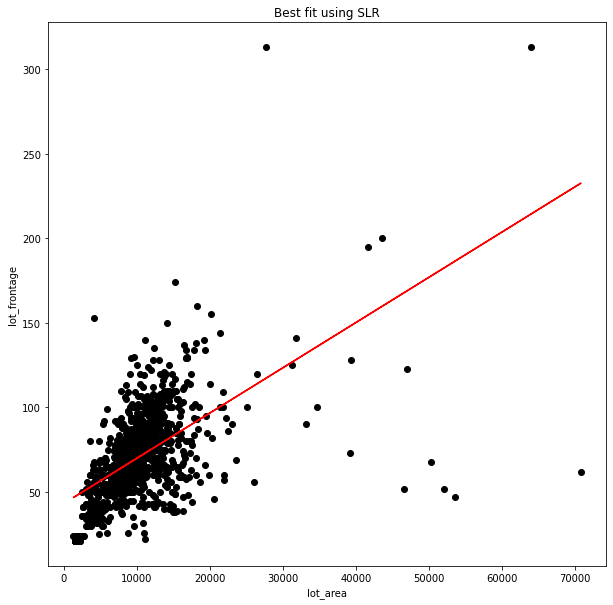

In [3297]:
# plot the data for SLR predictions
fig = plt.figure(figsize=(10,10))
ax = plt.gca()


# plot the data
ax.scatter(X_area, y_frontage, c='k')
ax.plot(X_area, 
         frontage_prediction, color='r');
plt.xlabel('lot_area')
plt.ylabel('lot_frontage')
plt.title('Best fit using SLR');

In [3298]:
#### get predicted values for NaN's
ames_test_frontage_nans = ames_test[['id','lot_frontage', 'lot_area']][ames_test['lot_frontage'].isnull() == True]
ames_test_frontage_nans.head()

ames_test_frontage_nans['lot_area'].shape

(160,)

In [3299]:
# get the predict values using the prediction model
frontage_prediction_for_nans = lr_lot_frontage.predict(ames_test_frontage_nans[['lot_area']])
frontage_prediction_for_nans.shape

(160,)

In [3300]:
ames_test.loc[ames_test['lot_frontage'].isnull(),'lot_frontage'] = frontage_prediction_for_nans

In [3306]:
# check the values have been updated
ames_test['lot_frontage'][ames_test['lot_frontage'].isnull()]

Series([], Name: lot_frontage, dtype: float64)

In [3302]:
# check data set
ames_test.isnull().sum().sort_values(ascending=False).head(5)

sale_type         0
yr_sold           0
year_remod/add    0
roof_style        0
roof_matl         0
dtype: int64

---

In [3303]:
# Save Data
ames_test.to_csv('./datasets/outputs/data_cleaning_test_1.0.csv')

---

## Could I answer the problem statement?

It is currently not possible because I need more information into the distributions and relationships between the features. I will be looking at this in the next workbook.

In [3432]:
ames_train['yr_sold'].max()

2010

In [3433]:
ames_train['yr_sold'].min()

2006

In [3435]:
ames_train['id'].size

2051

In [3436]:
ames_test['id'].size

879

In [3438]:
len(ames_test.columns)

80